## Librerias y Funciones

In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
#import plotly.express as px
#import plotly.graph_objects as go
from scipy import stats
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder

In [2]:
class PlotCorrelation():
    def __init__(self, df:pd.DataFrame, target_var:str, vars:list, vars_type:str):
        self.df = df
        self.target_var = target_var
        self.vars = vars
        self.vars_type = vars_type

    #CREA UN DATAFRAME VACIO PARA ALOJAR LAS CORRELACIONES
    def _get_correlation_dataframe(self) -> pd.DataFrame:
        df_corr = pd.DataFrame(index=self.vars, columns=['correlation'])
        return df_corr    

    #DEVUELVE EL NUMERO MULTIPLO DE 10 SUPERIOR INMEDIATO AL VALOR MAXIMO DE LA SERIE
    def _get_limit_value(self, values:pd.Series) -> float:
        limit_value = values.abs().round(2).max()
        limit_value = np.ceil(limit_value*10)/10
        return limit_value

    #FUNCION PARA PLOTEAR CORRELACION DE PUNTO BISERIAL
    def plot_biserial_point(self):
        df_corr = self._get_correlation_dataframe()
        corr_list = [stats.pointbiserialr(self.df[self.target_var], self.df[var]) for var in self.vars]
        for var, corr in zip(self.vars, corr_list):
            df_corr.loc[var, 'correlation'] = corr.statistic
        self._plot_correlation(df_corr)

    #FUNCION PARA PLOTEAR COEFICIENTE DE CONTIGENCIA
    def plot_coef_contingency(self):
        df_corr = self._get_correlation_dataframe()
        for var in self.vars:
            contingency_table = pd.crosstab(self.df[var], self.df[self.target_var])
            chi_2 = stats.chi2_contingency(contingency_table)
            df_corr.loc[var, 'correlation'] = math.sqrt(chi_2.statistic/(self.df.shape[0]+chi_2.statistic))
        self._plot_correlation(df_corr)

    #FUNCION PARA PLOTEAR EL GRAFICO DE BARRAS
    def _plot_correlation(self, df_corr:pd.DataFrame):
        colors = ['#000E9E' if corr < 0 else '#3DB2DA' for corr in df_corr.correlation]
        limit_value = self._get_limit_value(df_corr.correlation)
        plt.style.use("bmh")
        plt.figure(figsize=(8,5))  
        sns.barplot(x=df_corr.correlation, y=df_corr.index, hue=df_corr.index, palette=colors)
        plt.title(f'Correlacion de variable objetivo con variables {self.vars_type}', fontsize=14)
        plt.xlabel('Coeficiente de correlacion')
        plt.ylabel(f'Variables {self.vars_type}')
        plt.xlim(-1*limit_value, limit_value)
        plt.axvline(x=0, color='black', linestyle='-')
        plt.tight_layout()
        plt.show()
        plt.style.use("default")  

### APERTURA DE ARCHIVO

In [3]:
df = pd.read_csv('Hotel_Reservations_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36133 entries, 0 to 36132
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   36133 non-null  int64  
 1   Booking_ID              36133 non-null  object 
 2   num_adults              36133 non-null  int64  
 3   num_children            36133 non-null  int64  
 4   weekend_nights          36133 non-null  int64  
 5   week_nights             36133 non-null  int64  
 6   total_nights            36133 non-null  int64  
 7   meal_plan               36133 non-null  object 
 8   car_parking             36133 non-null  int64  
 9   room_type               36133 non-null  object 
 10  lead_time               36133 non-null  int64  
 11  arrival_year            36133 non-null  int64  
 12  arrival_month           36133 non-null  int64  
 13  arrival_day             36133 non-null  int64  
 14  arrival_season          36133 non-null

### Analisis de correlaciones

En esta seccion perteneciente al ***EDA*** se analizaran las correlaciones de todas las variables contra la variable objetivo ***booking_status_id***, esta representa la dicotomia de la variable ***booking_status*** de manera numerica para poder utilizar los metodos de correlacion.

#### Separacion de variables segun su tipo

In [4]:
numeric_var = ['num_adults', 'num_children', 'weekend_nights','week_nights',
                'total_nights', 'lead_time','num_prev_cancellations',
                'num_prev_not_canceled', 'avg_price_room', 'num_sp_requests']

nominal_var = ['repeated_guest', 'car_parking', 'arrival_season_cod', 'mkt_segment_cod']

ordinal_var = ['meal_plan_cod','room_type_cod']

#### Matriz de correlacion (Pearlson)

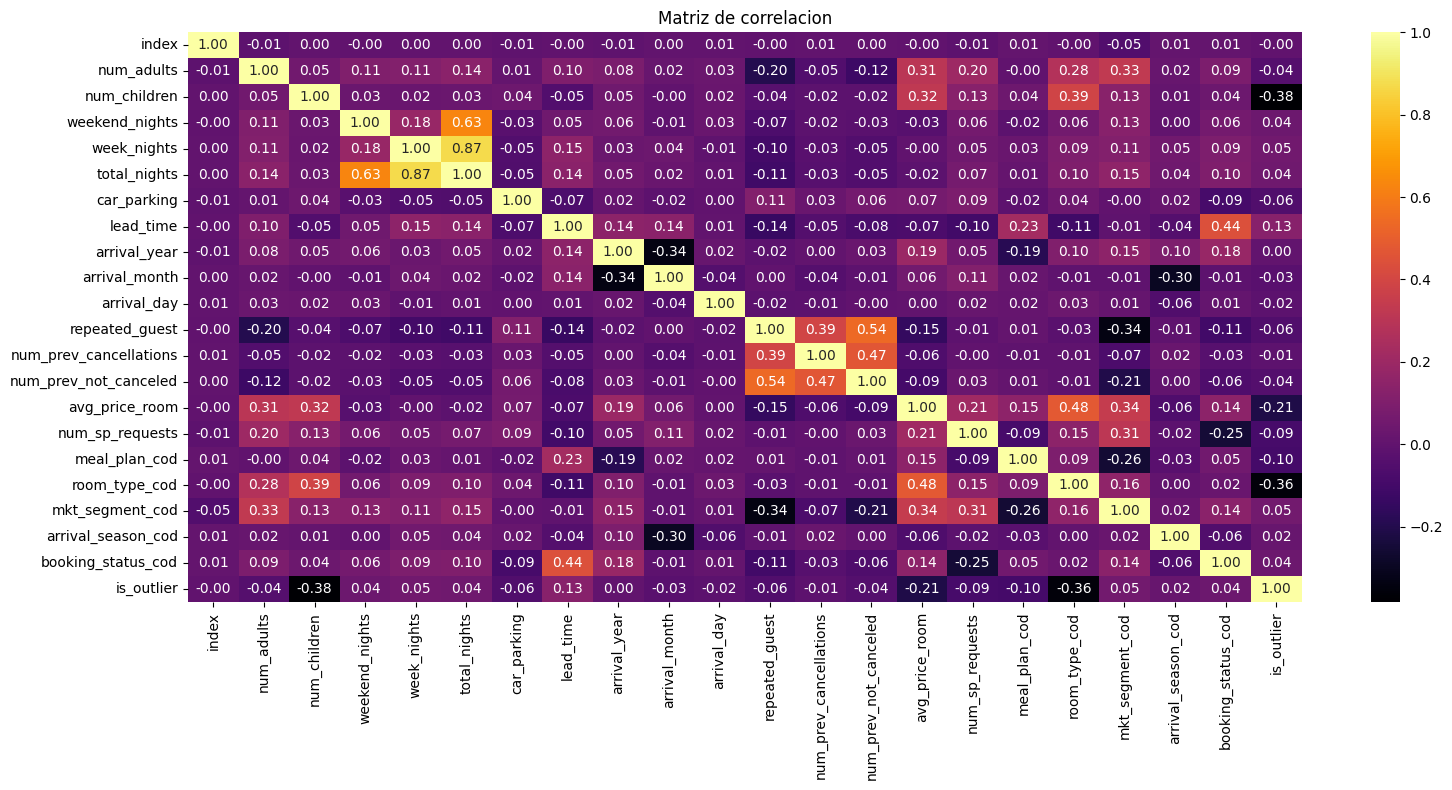

In [5]:
matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16,8))
sns.heatmap(matrix, fmt='.2f', annot=True, cmap='inferno')
plt.title('Matriz de correlacion')
plt.tight_layout()
plt.show()

#### Correlacion de variable ***booking_status*** con variables cuantitativas y ordinales

Se utiliza el ***coeficiente de correlacion punto biserial*** para determinar la relacion entre las variables cuantitativas y la variable de interes ***booking_status*** que es de tipo nominal dicotomica.

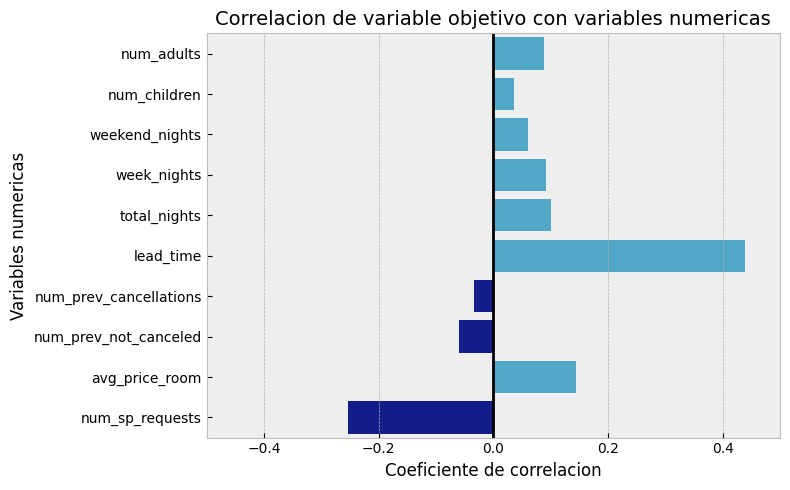

In [6]:
PlotCorrelation(df, 'booking_status_cod', numeric_var, 'numericas').plot_biserial_point()

#### Correlacion de variable objetivo ***booking_status*** con variables de origen nominal

Se utiliza la ***coeficiente de contingencia*** para determinar la relacion entre las variables nominales y la variable de interes ***booking_status*** que es de tipo nominal dicotomica. Para ello se obtiene el estadisitico de prueba ***Chi cuadrado*** utilizando la libreria ***scipy*** para posteriormente obtener el coeficiente con la formula que se muestra acontinuacion:
$$
C = \sqrt{\frac{x^2}{N+x^2}}
$$
X²: Estadistico Chi²<br>
N: Cantidadad de observaciones totales<br>
C: coeficiente de contingencia<br>

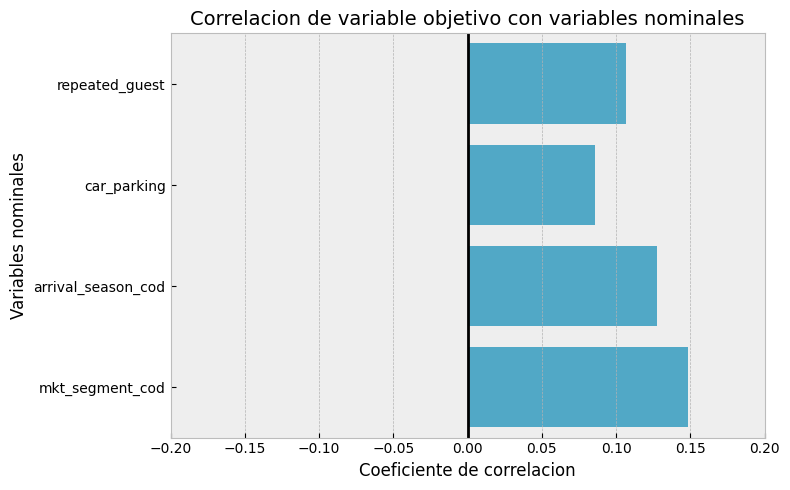

In [7]:
PlotCorrelation(df, 'booking_status_cod', nominal_var, 'nominales').plot_coef_contingency()

### Graficos de exploracion

#### Comportamiento de la reservas

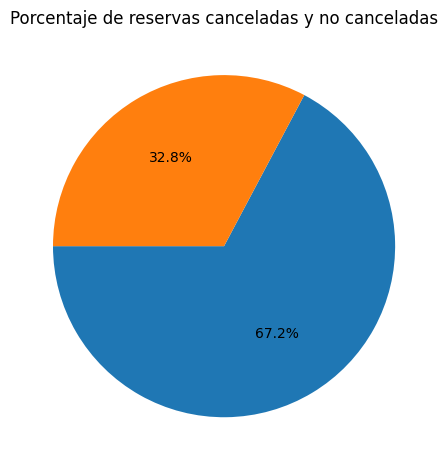

In [8]:
#GRAFICO DE TORTA RESERVAS CANCELADAS Y NO CANCELADAS
count = df.booking_status.value_counts()
plt.pie(count, autopct='%1.1f%%', startangle=180)
plt.title('Porcentaje de reservas canceladas y no canceladas')

plt.tight_layout()
plt.show()

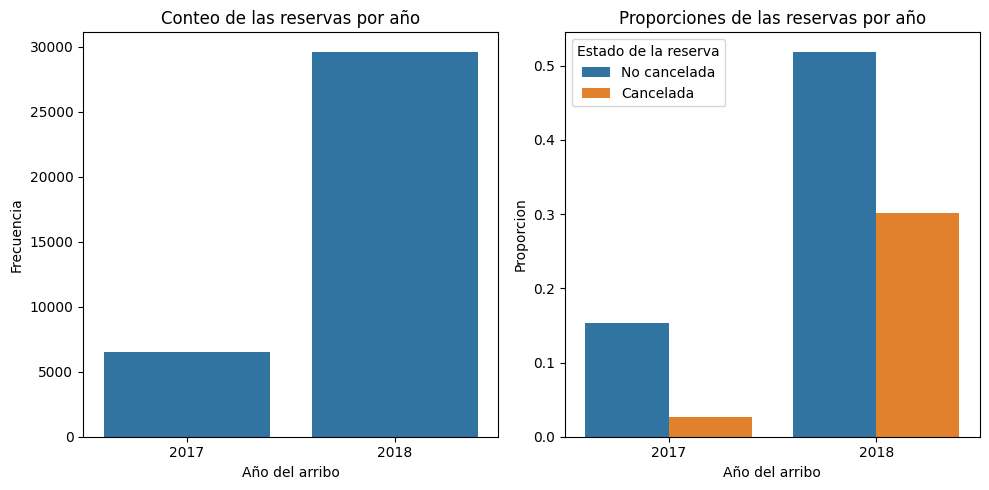

In [9]:
#COMPORTAMIENTO ANUAL DE LAS RESERVAS
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.countplot(x=df.arrival_year,ax=ax[0])
ax[0].set_title('Conteo de las reservas por año')
ax[0].set_xlabel('Año del arribo')
ax[0].set_ylabel('Frecuencia')

sns.countplot(x=df.arrival_year,hue=df.booking_status, stat='proportion', ax=ax[1])
ax[1].set_title('Proporciones de las reservas por año')
ax[1].set_xlabel('Año del arribo')
ax[1].set_ylabel('Proporcion')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()

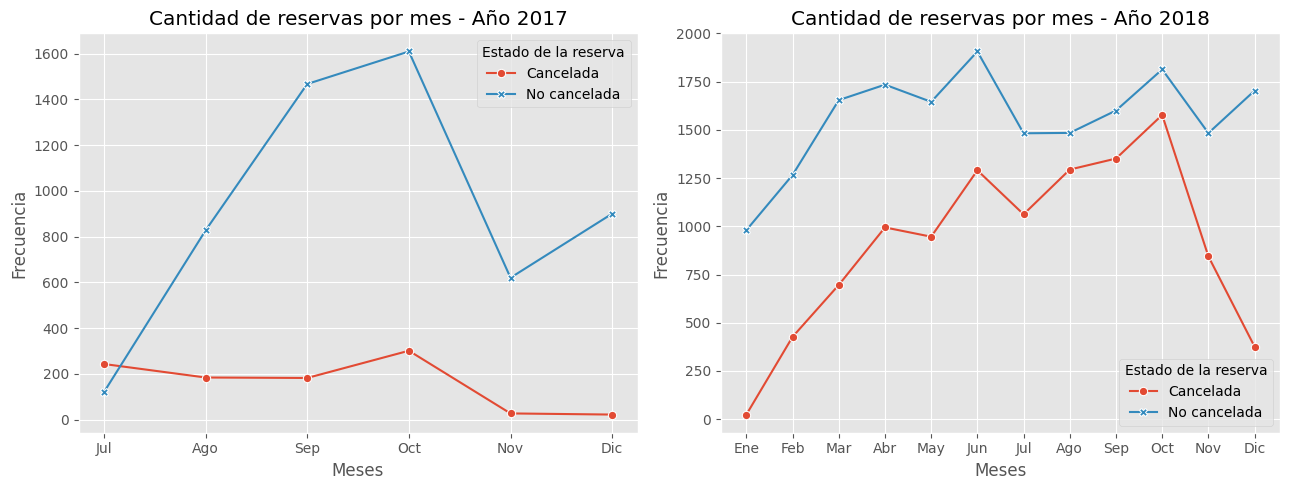

In [10]:
#COMPORTAMIENTO MENSUAL DE LAS RESERVAS
bookings = df.groupby(['arrival_year','arrival_month','booking_status'])['booking_status'].count().reset_index(name='count')
months = ['Ene','Feb','Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

#GRAFICO
mpl.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

#AÑO 2017
data=bookings.loc[bookings.arrival_year==2017]
sns.lineplot(data=data, x='arrival_month', y='count', hue='booking_status', ax=ax[0], style='booking_status', markers=True, dashes=False)
ax[0].set_title('Cantidad de reservas por mes - Año 2017')
ax[0].set_xlabel('Meses')
ax[0].set_xticks(ticks=data.arrival_month.unique(), labels=months[6:])
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

#AÑO 2018
data=bookings.loc[bookings.arrival_year==2018]
sns.lineplot(data=data, x='arrival_month', y='count', hue='booking_status', ax=ax[1], style='booking_status', markers=True, dashes=False)
ax[1].set_title('Cantidad de reservas por mes - Año 2018')
ax[1].set_xlabel('Meses')
ax[1].set_xticks(ticks=data.arrival_month.unique(), labels=months)
ax[1].set_ylabel('Frecuencia')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()
mpl.style.use('default')

#### Distribucion de la variable ***avg_price_room***

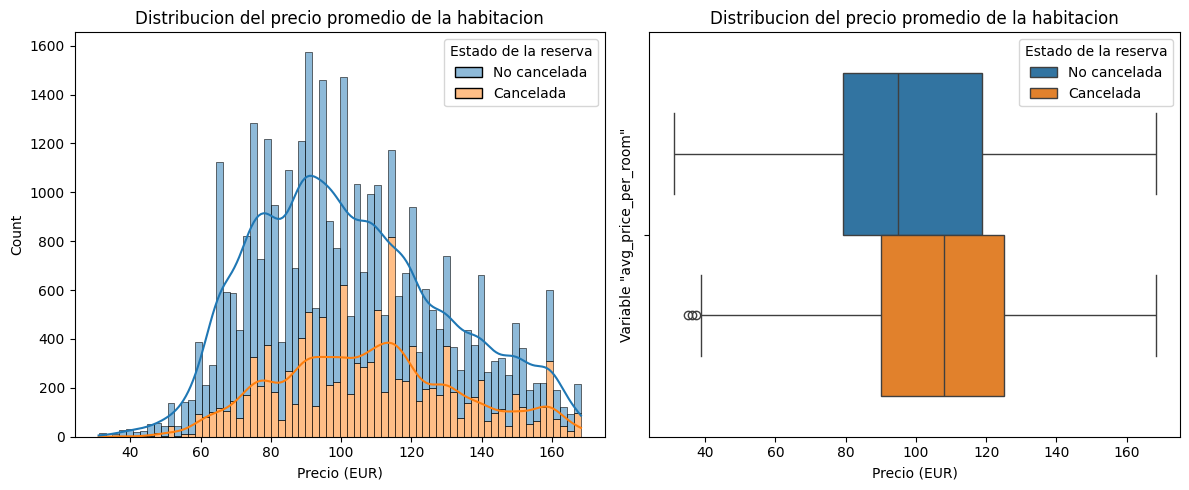

In [11]:
#DISTRIBUCION VARIABLE AVG_PRICE_ROOM
#mpl.style.use('bmh')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(x=df.avg_price_room, hue=df.booking_status, multiple='stack',bins=70, kde=True, ax=ax[0])
ax[0].set_title('Distribucion del precio promedio de la habitacion')
ax[0].set_xlabel('Precio (EUR)')
ax[0].get_legend().set_title('Estado de la reserva')

sns.boxplot(x=df.avg_price_room, hue=df.booking_status, ax=ax[1])
ax[1].set_title('Distribucion del precio promedio de la habitacion')
ax[1].set_xlabel('Precio (EUR)')
ax[1].set_ylabel('Variable "avg_price_per_room"')
ax[1].get_legend().set_title('Estado de la reserva')
plt.tight_layout()
plt.show()

#### Distribucion de la variable ***lead_time***

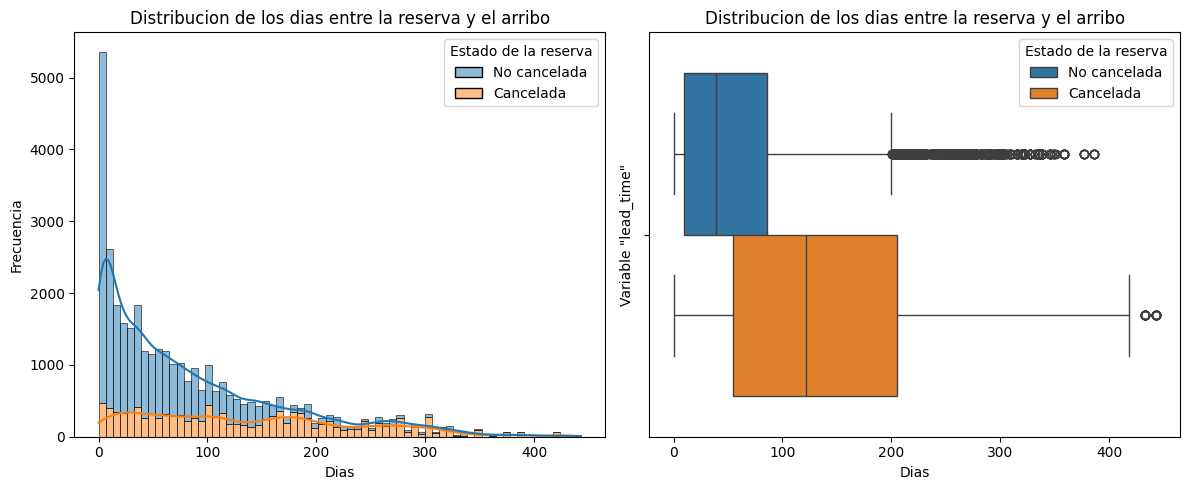

In [12]:
#DISTRIBUCION VARIABLE AVG_PRICE_ROOM
#mpl.style.use('bmh')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(x=df.lead_time, hue=df.booking_status, multiple='stack', kde=True, ax=ax[0])
ax[0].set_title('Distribucion de los dias entre la reserva y el arribo')
ax[0].set_xlabel('Dias')
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

sns.boxplot(x=df.lead_time, hue=df.booking_status, ax=ax[1])
ax[1].set_title('Distribucion de los dias entre la reserva y el arribo')
ax[1].set_xlabel('Dias')
ax[1].set_ylabel('Variable "lead_time"')
ax[1].get_legend().set_title('Estado de la reserva')
plt.tight_layout()
plt.show()

#### Distribucion de la variable ***num_sp_requests***

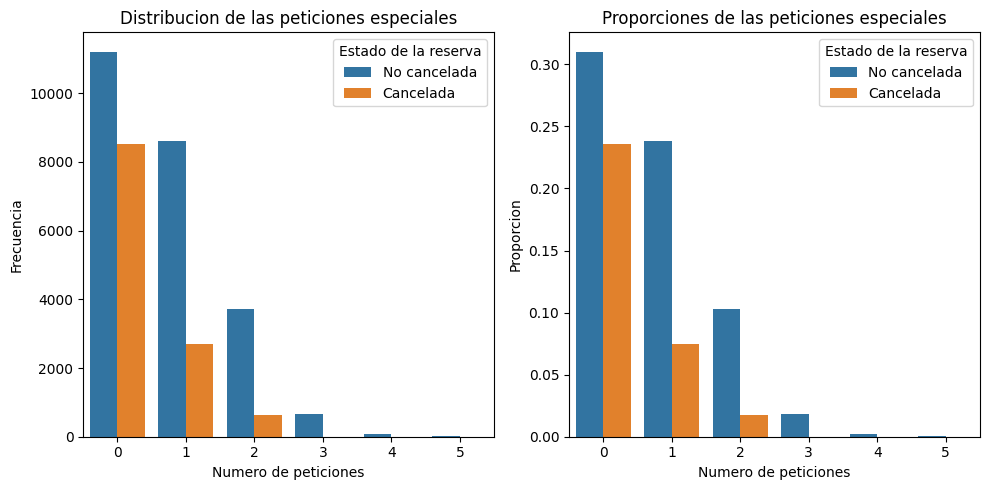

In [13]:
#DISTRIBUCION DE LAS PETICIONES ESPECIALES
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.countplot(x=df.num_sp_requests,ax=ax[0], hue=df.booking_status)
ax[0].set_title('Distribucion de las peticiones especiales')
ax[0].set_xlabel('Numero de peticiones')
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

sns.countplot(x=df.num_sp_requests,hue=df.booking_status, stat='proportion', ax=ax[1])
ax[1].set_title('Proporciones de las peticiones especiales')
ax[1].set_xlabel('Numero de peticiones')
ax[1].set_ylabel('Proporcion')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()

#### Distribucion de la variable ***mkt_segment***

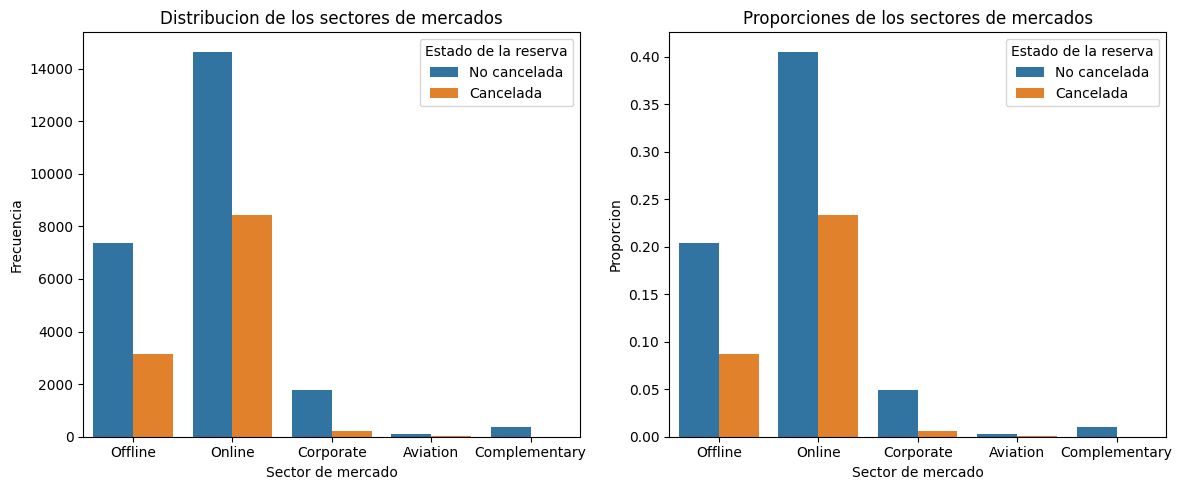

In [14]:
#DISTRIBUCION DE LOS SECTORES DE MERCADO
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(x=df.mkt_segment,ax=ax[0], hue=df.booking_status)
ax[0].set_title('Distribucion de los sectores de mercados')
ax[0].set_xlabel('Sector de mercado')
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

sns.countplot(x=df.mkt_segment,hue=df.booking_status, stat='proportion', ax=ax[1])
ax[1].set_title('Proporciones de los sectores de mercados')
ax[1].set_xlabel('Sector de mercado')
ax[1].set_ylabel('Proporcion')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()

#### Analisis bivariado: ***lead_time*** vs ***avg_price_room*** 

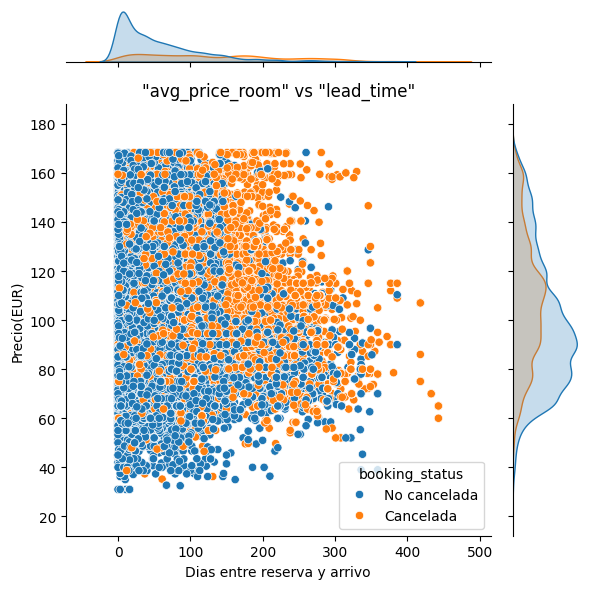

In [20]:
#GRAFICO DE RELACION ENTRE VARIABLES AVG_PRICE_ROOM Y LEAD_TIME
sns.jointplot(x=df.lead_time, y=df.avg_price_room, hue=df.booking_status)
plt.title('"avg_price_room" vs "lead_time"')
plt.ylabel('Precio(EUR)')
plt.xlabel('Dias entre reserva y arrivo')
plt.tight_layout()
plt.show()

#### Analisis bivariado: ***lead_time*** vs ***num_sp_requests***

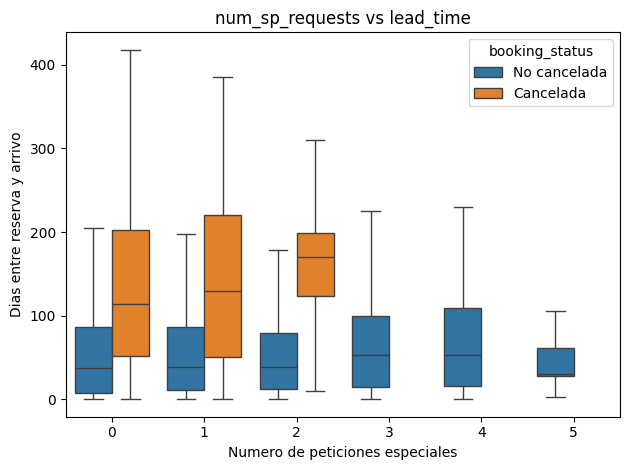

In [16]:
sns.boxplot(y=df.lead_time, x=df.num_sp_requests, hue=df.booking_status, showfliers=False)
plt.title('num_sp_requests vs lead_time')
plt.xlabel('Numero de peticiones especiales')
plt.ylabel('Dias entre reserva y arrivo')
plt.tight_layout()
plt.show()

#### Analisis bivariado: ***lead_time*** vs ***mkt_segment***

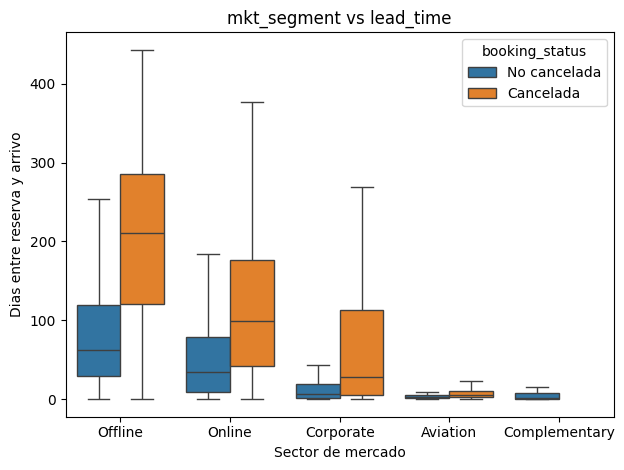

In [17]:
sns.boxplot(y=df.lead_time, x=df.mkt_segment, hue=df.booking_status, showfliers=False)
plt.title('mkt_segment vs lead_time')
plt.xlabel('Sector de mercado')
plt.ylabel('Dias entre reserva y arrivo')
plt.tight_layout()
plt.show()